# **Comparison of Decision Tree and Random Forest Models using PySpark**

2309042 - Riya Saroj

2309043 - Sanika Shinde

2309045 - Rashi Shetty

## ***1. Initializing SPARK Session***

Creating a *Spark session* to enable PySpark functionalities, and importing essential modules for feature transformation, classification, and evaluation of decision tree and random forest models.

In [1]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import VectorIndexer, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when, monotonically_increasing_id, expr, count
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from imblearn.over_sampling import ADASYN
from typing import Dict, List
from pyspark.sql.functions import col
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

In [178]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
from sklearn.metrics import roc_curve, auc

In [3]:
spark = SparkSession.builder.appName("rashi").getOrCreate()

## ***2. Loading the Dataset***

Fetching the 'Bank Marketing dataset' from Kaggle as a csv and storing the features in `X` and the target labels in `y` as pandas DataFrames.
Converting the Pandas DataFrames - feature set `X` and target labels `y` - into PySpark DataFrames.

In [4]:
data_sdf = spark.read.csv("C:/Users/rashi/Downloads/bank-direct-marketing-campaigns.csv", header=True, inferSchema=True)
features_sdf = data_sdf.drop("y")  
target_sdf = data_sdf.select("y")

In [5]:
print(f"Number of records in features_sdf: {features_sdf.count()}")
print(f"Number of records in target_sdf: {target_sdf.count()}")

Number of records in features_sdf: 41188
Number of records in target_sdf: 41188


## ***3. Exploratory Data Analysis***

In [5]:
from pyspark.sql.functions import when
target_sdf = target_sdf.withColumn("y", when(target_sdf["y"] == "yes", 1).otherwise(0))
data_sdf = data_sdf.withColumn("y", when(data_sdf["y"] == "yes", 1).otherwise(0))
target_sdf.show(5)

+---+
|  y|
+---+
|  0|
|  0|
|  0|
|  0|
|  0|
+---+
only showing top 5 rows



In [6]:
target_sdf.groupBy('y').count().show()
counts = target_sdf.groupBy('y').count().collect()

for row in counts:
    print(f"Number of {row['y']} instances: {row['count']}")

+---+-----+
|  y|count|
+---+-----+
|  1| 4640|
|  0|36548|
+---+-----+

Number of 1 instances: 4640
Number of 0 instances: 36548


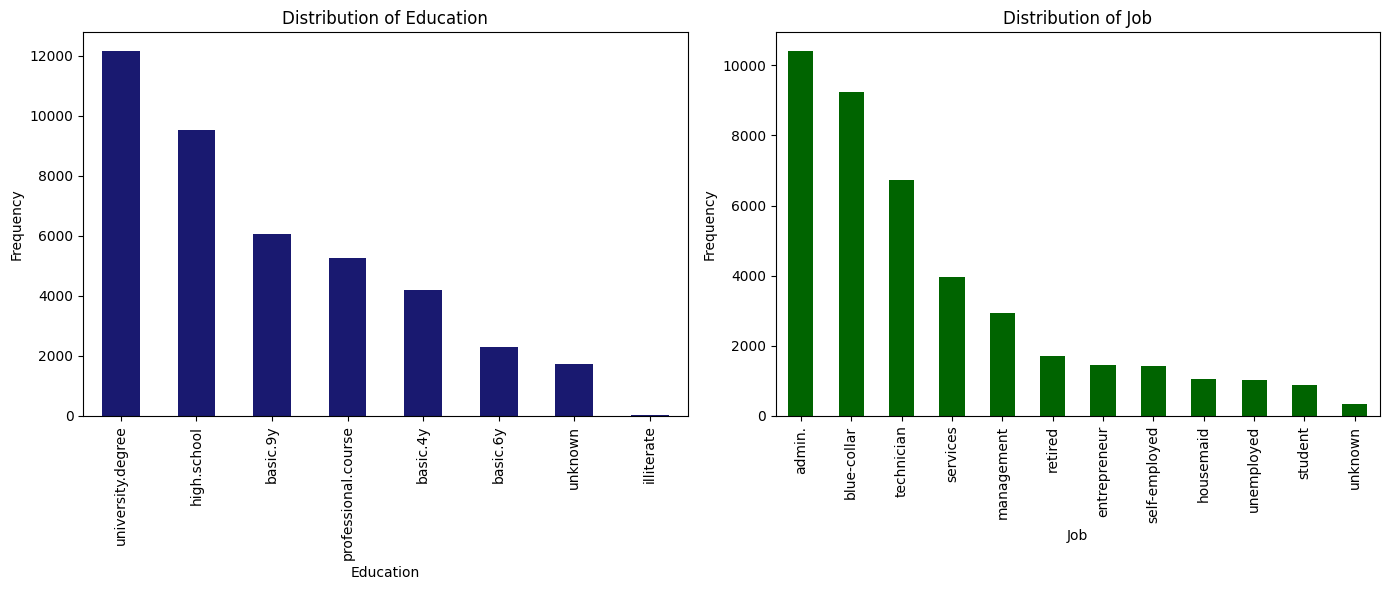

In [10]:
pdf = features_sdf.toPandas()
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pdf['education'].value_counts().plot(kind='bar', color='#003366')
plt.title('Distribution of Education')
plt.xlabel('Education')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
pdf['job'].value_counts().plot(kind='bar', color='#007A33')
plt.title('Distribution of Job')
plt.xlabel('Job')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

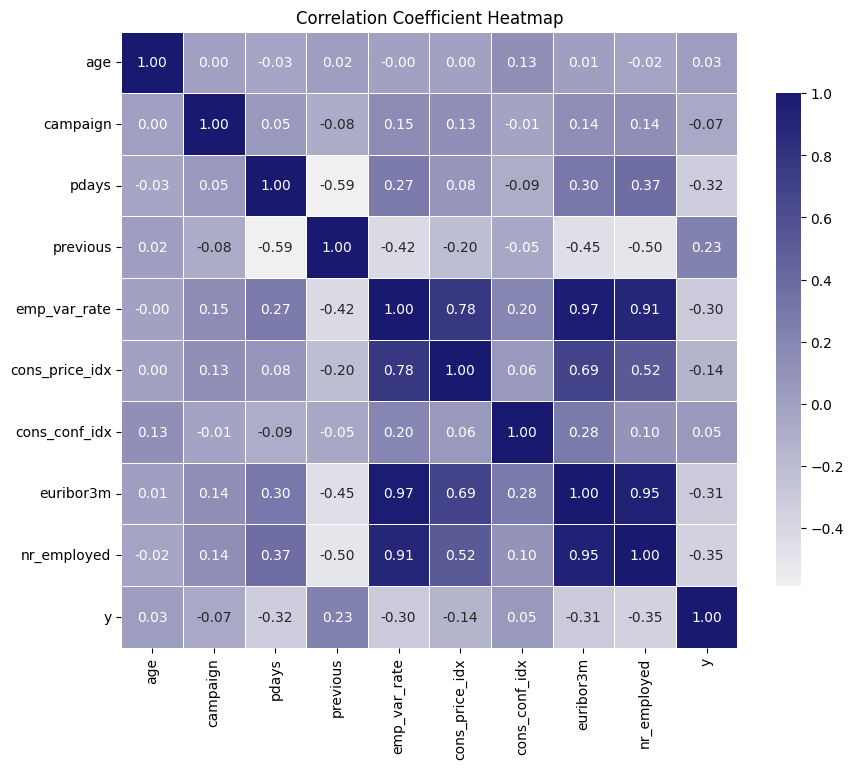

In [9]:
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
vector_sdf = assembler.transform(data_sdf)

correlation_matrix = Correlation.corr(vector_sdf, "features").head()[0]
correlation_array = correlation_matrix.toArray()

correlation_df = pd.DataFrame(correlation_array, columns=numerical_cols, index=numerical_cols)
cmap = sns.light_palette("midnightblue", as_cmap=True) 

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap=cmap, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Coefficient Heatmap')
plt.show()

## ***4. Data Preprocessing***

In [6]:
columns_to_handle = ["poutcome", "job", "education"]
for column in columns_to_handle:
    features_sdf = features_sdf.withColumn(column, 
                                           F.when(F.isnan(F.col(column)), "unknown")
                                           .otherwise(F.col(column)))

In [7]:
features_sdf = features_sdf.withColumn("education",
    when(col("education").isin("basic.4y", "basic.6y", "basic.9y"), "basic")
    .otherwise(col("education"))
)
features_sdf.select("education").distinct().show()

+-------------------+
|          education|
+-------------------+
|              basic|
|        high.school|
|  university.degree|
|            unknown|
|         illiterate|
|professional.course|
+-------------------+



**Binary Encoding:** Transforming the target column - `y` and features - `default`, `housing`, `loan` in the PySpark DataFrames, where "yes" is encoded as 1 and all other values as 0.

In [8]:
columns = ["default", "housing", "loan"]
for col in columns:
    features_sdf = features_sdf.withColumn(col, when(features_sdf[col] == "yes", 1).otherwise(0))

Reducing dimensionality and eliminating potentially irrelevant features.

Calculating the missing values for each column in the PySpark DataFrame: The dataset has no missing values

In [18]:
missing_values = features_sdf.select([sum(col(c).isNull().cast("int")).alias(c) for c in features_sdf.columns])
missing_values.show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|    0|       0|       0|           0|             0|            0|        0|          0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+



In [9]:
features_sdf=features_sdf.drop("previous", "day_of_week", "contact")

In [10]:
features_sdf = features_sdf.withColumn("pdays",when(features_sdf["pdays"] == -1, 0).otherwise(1))

In [11]:
features_sdf = features_sdf.withColumn(
    "campaign",
    when(features_sdf["campaign"] > 6, 6).otherwise(features_sdf["campaign"])
)
campaign_counts = features_sdf.groupBy("campaign").count().orderBy("campaign")
campaign_counts.show()

+--------+-----+
|campaign|count|
+--------+-----+
|       1|17642|
|       2|10570|
|       3| 5341|
|       4| 2651|
|       5| 1599|
|       6| 3385|
+--------+-----+



In [14]:
data_sdf.createOrReplaceTempView("features")

job_subscription_analysis = spark.sql("""
    SELECT job, 
           COUNT(*) AS count, 
           SUM(CASE WHEN y = '1' THEN 1 ELSE 0 END) AS subscribed_count,
           AVG(balance) AS avg_balance
    FROM features
    GROUP BY job
    ORDER BY subscribed_count DESC
""")

job_subscription_analysis.show()
job_subscription_distribution = data_sdf.groupBy("job", "y").count().orderBy("job", "y")
job_subscription_distribution.show(truncate=False, n=data_sdf.count())

+-------------+-----+----------------+------------------+
|          job|count|subscribed_count|       avg_balance|
+-------------+-----+----------------+------------------+
|   management| 9458|               0|1763.6168323112709|
|       admin.| 5171|               0| 1135.838909301876|
|      retired| 2264|               0| 1984.215106007067|
|      unknown|  288|               0| 1772.357638888889|
|     services| 4154|               0| 997.0881078478575|
|   unemployed| 1303|               0|1521.7459708365311|
|      student|  938|               0|1388.0607675906183|
|  blue-collar| 9732|               0|1078.8266543362104|
|self-employed| 1579|               0|1647.9708676377454|
|   technician| 7597|               0|1252.6320916151112|
|    housemaid| 1240|               0|1392.3951612903227|
| entrepreneur| 1487|               0| 1521.470073974445|
+-------------+-----+----------------+------------------+

+-------------+---+-----+
|job          |y  |count|
+-------------+---+

In [15]:
data = {'job': ['admin.', 'admin.', 'blue-collar', 'blue-collar', 'entrepreneur', 'entrepreneur', 'housemaid', 'housemaid', 'management', 'management', 'retired', 'retired', 'self-employed', 'self-employed', 'services', 'services', 'student', 'student', 'technician', 'technician', 'unemployed', 'unemployed', 'unknown', 'unknown'],
    'y': ['no', 'yes'] * 12,
    'count': [4540, 631, 9024, 708, 1364, 123,  1131, 109, 8157, 1301, 1748, 516, 1392, 187, 3785, 369, 669, 269, 6757, 840, 1101, 202, 254, 34]}

df = pd.DataFrame(data)
total_counts = df.groupby('job')['count'].sum().reset_index()
total_counts.columns = ['job', 'total_count']

subscribed_counts = df[df['y'] == 'yes'].groupby('job')['count'].sum().reset_index()
subscribed_counts.columns = ['job', 'subscribed_count']

merged_df = pd.merge(total_counts, subscribed_counts, on='job', how='left').fillna(0)
merged_df['conversion_percentage'] = (merged_df['subscribed_count'] / merged_df['total_count']) * 100

sorted_df = merged_df[['job', 'conversion_percentage']].sort_values(by='conversion_percentage', ascending=False)
print(sorted_df)

              job  conversion_percentage
8         student              28.678038
5         retired              22.791519
10     unemployed              15.502686
4      management              13.755551
0          admin.              12.202669
6   self-employed              11.842939
11        unknown              11.805556
9      technician              11.056996
7        services               8.883004
3       housemaid               8.790323
2    entrepreneur               8.271688
1     blue-collar               7.274969


In [16]:
df2=job_subscription_analysis.toPandas()
df = merged_df.merge(df2[['job', 'avg_balance']], on='job', how='left')

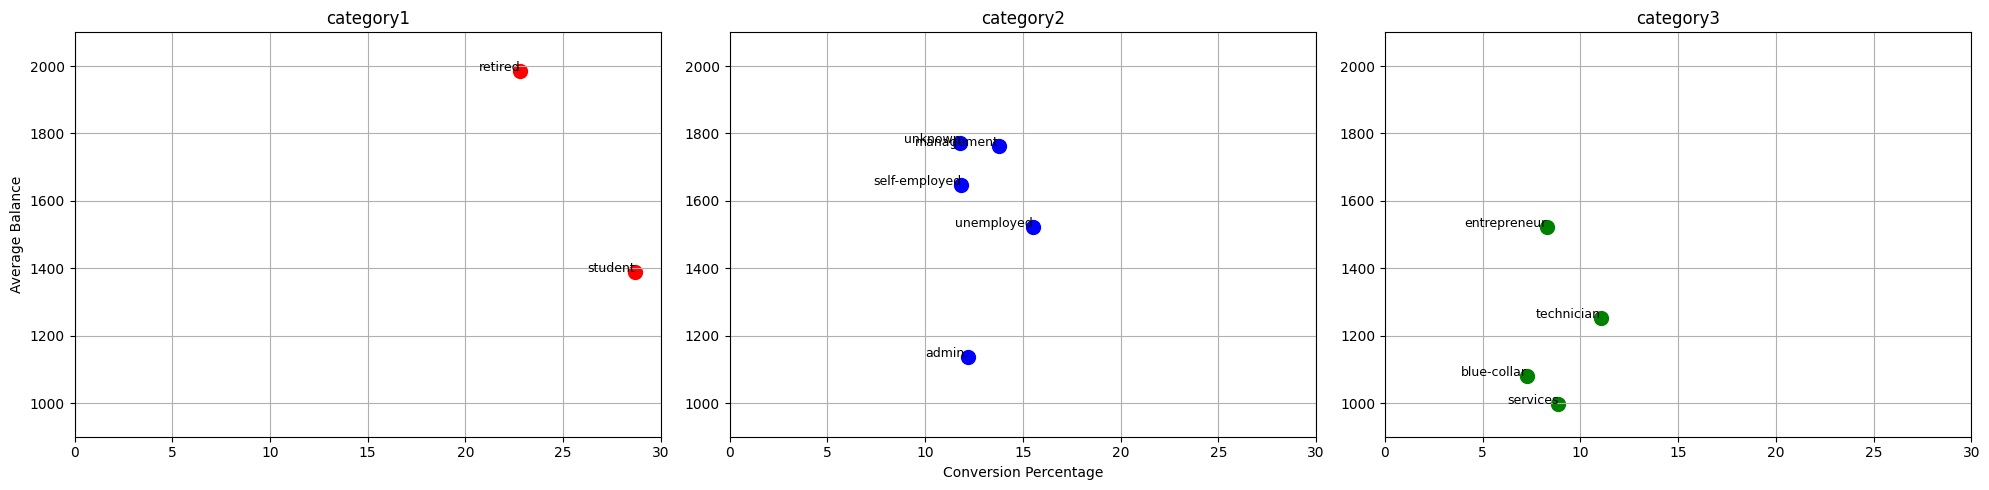

In [136]:
x_min, x_max = 0, 30
y_min, y_max = 900, 2100
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

category1 = df[df['job'].isin(['student', 'retired'])]
for _, row in category1.iterrows():
    if row['subscribed_count']:
        axs[0].scatter(row['conversion_percentage'], row['avg_balance'], color='red', s=100)
        axs[0].text(row['conversion_percentage'], row['avg_balance'], row['job'], fontsize=9, ha='right')
axs[0].set_title('category1')
axs[0].set_ylabel('Average Balance')
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].grid()

category2 = df[df['job'].isin(['management', 'unemployed', 'self-employed', 'admin.', 'unknown'])]
for _, row in category2.iterrows():
    if row['subscribed_count']:
        axs[1].scatter(row['conversion_percentage'], row['avg_balance'], color='blue', s=100)
        axs[1].text(row['conversion_percentage'], row['avg_balance'], row['job'], fontsize=9, ha='right')
axs[1].set_title('category2')
axs[1].set_xlabel('Conversion Percentage')
axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
axs[1].grid()

category3 = df[df['job'].isin(['blue-collar', 'services', 'technician', 'entrepreneur'])]
for _, row in category3.iterrows():
    if row['subscribed_count']:
        axs[2].scatter(row['conversion_percentage'], row['avg_balance'], color='green', s=100)
        axs[2].text(row['conversion_percentage'], row['avg_balance'], row['job'], fontsize=9, ha='right')
axs[2].set_title('category3')
axs[2].set_xlim(x_min, x_max)
axs[2].set_ylim(y_min, y_max)
axs[2].grid()

plt.tight_layout()
plt.show()

**Job Type Clusters:**

1. **category1**:
   - **Student**: High conversion rate (28.68%), moderate total count, low average balance, indicating strong engagement.
   - **Retired**: High conversion rate (22.79%) with a moderate total count, indicating effective targeting.

2. **category2**:
   - **Unemployed**: Moderate conversion rate (15.50%), lower average balance compared to high engagement groups, suggesting potential for improvement.
   - **Management**: Moderate conversion rate (13.76%) and high total count, indicating substantial potential engagement.
   - **Admin.**: Moderate conversion rate (12.20%) with decent total count and average balance, suggesting room for growth in engagement strategies.
   - **Self-Employed**: Moderate conversion rate (11.84%) with a relatively low subscribed count, indicating potential for higher engagement.
   - **Unknown**: Moderate conversion rate (11.81%) with a low subscribed count, suggesting lack of targeted engagement.
     
3. **category3**:
   - **Technician**: Lower conversion rate (11.06%), high total count but lower engagement suggests potential barriers to conversion.
   - **Services**: Low conversion rate (8.88%), decent total count but low engagement.
   - **Housemaid**: Low conversion rate (8.79%), higher total count but limited engagement opportunities.
   - **Entrepreneur**: Low conversion rate (8.27%) and low subscribed count, suggesting a lack of interest in engagement strategies.
   - **Blue-Collar**: The lowest conversion rate (7.27%), indicating challenges in attracting this job type.

In [12]:
features_sdf = features_sdf.withColumn(
    "job",
    when(features_sdf["job"].isin('student', 'retired'), '1')
    .when(features_sdf["job"].isin('unemployed', 'management', 'admin.', 'self-employed', 'unknown'), '2')
    .when(features_sdf["job"].isin('technician', 'services', 'housemaid', 'entrepreneur', 'blue-collar'), '3')
)

features_sdf.show(5)

+---+---+-------+-----------+-------+-------+----+-----+--------+-----+-----------+------------+--------------+-------------+---------+-----------+
|age|job|marital|  education|default|housing|loan|month|campaign|pdays|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|
+---+---+-------+-----------+-------+-------+----+-----+--------+-----+-----------+------------+--------------+-------------+---------+-----------+
| 56|  3|married|      basic|      0|      0|   0|  may|       1|    1|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|
| 57|  3|married|high.school|      0|      0|   0|  may|       1|    1|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|
| 37|  3|married|high.school|      0|      1|   0|  may|       1|    1|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|
| 40|  2|married|      basic|      0|      0|   0|  may|       1|    1|nonexistent|         1.1|        93.994| 

## ***5. Binning Continuous Features Using Spark SQL***

In [13]:
quantiles = features_sdf.approxQuantile('age', [0.25, 0.75], 0.0)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

features_sdf = features_sdf.withColumn(
    'age',
    F.when(features_sdf['age'] < lower_bound, lower_bound)
    .when(features_sdf['age'] > upper_bound, upper_bound)
    .otherwise(features_sdf['age'])
)

Binning the `age` feature into defined age groups using a SQL `CASE` expression.

Binning helps to reduce the impact of noise and outliers, simplifies the model by grouping continuous variables into discrete categories, enhances interpretability, and can improve model performance by capturing non-linear relationships.

In [14]:
age_bin_expr = """
CASE
    WHEN age <= 20 THEN '0-20'
    WHEN age BETWEEN 21 AND 40 THEN '21-40'
    WHEN age BETWEEN 41 AND 60 THEN '41-60'
    WHEN age BETWEEN 61 AND 80 THEN '61-80'
    ELSE '81+'
END
"""
features_sdf.select(expr(age_bin_expr).alias("age_bin")).groupBy("age_bin").agg(count("*").alias("count")).orderBy("age_bin").show()

+-------+-----+
|age_bin|count|
+-------+-----+
|   0-20|  140|
|  21-40|23628|
|  41-60|16510|
|  61-80|  910|
+-------+-----+



Since the age range defined bins are imbalanced, calculating quantiles for the age feature to create balanced bins

In [15]:
quantiles = features_sdf.approxQuantile("age", [0.25, 0.5, 0.75], 0.01)
quantile_bin_expr = f"""
CASE
    WHEN age <= {quantiles[0]} THEN 'Q1'
    WHEN age BETWEEN {quantiles[0]} AND {quantiles[1]} THEN 'Q2'
    WHEN age BETWEEN {quantiles[1]} AND {quantiles[2]} THEN 'Q3'
    ELSE 'Q4'
END
"""
features_sdf.select(expr(quantile_bin_expr).alias("quantile_bin")).groupBy("quantile_bin").agg(count("*").alias("count")).orderBy("quantile_bin").show()

+------------+-----+
|quantile_bin|count|
+------------+-----+
|          Q1|11176|
|          Q2| 9999|
|          Q3|10140|
|          Q4| 9873|
+------------+-----+



**Ordinal Encoding:** Each value of 'age' is categorized into Q1, Q2, Q3, or Q4, creating balanced quantile bins for the `age` feature and encoding them as numerical values.

In [16]:
from pyspark.sql.functions import col, when
quantile_bins = [quantiles[0], quantiles[1], quantiles[2]] 

bin_expr = when(col("age") <= quantile_bins[0], "Q1") \
    .when(col("age") < quantile_bins[1], "Q2") \
    .when(col("age") < quantile_bins[2], "Q3") \
    .otherwise("Q4")

features_sdf = features_sdf.withColumn("age_bin", bin_expr)

features_sdf = features_sdf.withColumn("age_bin_encoded",
    when(col("age_bin") == "Q1", 1)
    .when(col("age_bin") == "Q2", 2)
    .when(col("age_bin") == "Q3", 3)
    .otherwise(4)
)

features_sdf.select("age", "age_bin", "age_bin_encoded").show(4)

+----+-------+---------------+
| age|age_bin|age_bin_encoded|
+----+-------+---------------+
|56.0|     Q4|              4|
|57.0|     Q4|              4|
|37.0|     Q2|              2|
|40.0|     Q3|              3|
+----+-------+---------------+
only showing top 4 rows



In [17]:
features_sdf = features_sdf.drop("age", "age_bin")
features_sdf = features_sdf.withColumnRenamed("age_bin_encoded", "age")

In [18]:
features_sdf.show(5)

+---+-------+-----------+-------+-------+----+-----+--------+-----+-----------+------------+--------------+-------------+---------+-----------+---+
|job|marital|  education|default|housing|loan|month|campaign|pdays|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|age|
+---+-------+-----------+-------+-------+----+-----+--------+-----+-----------+------------+--------------+-------------+---------+-----------+---+
|  3|married|      basic|      0|      0|   0|  may|       1|    1|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  4|
|  3|married|high.school|      0|      0|   0|  may|       1|    1|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  4|
|  3|married|high.school|      0|      1|   0|  may|       1|    1|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0|  2|
|  2|married|      basic|      0|      0|   0|  may|       1|    1|nonexistent|         1.1|        93.994|     

## ***6. Encoding Categorical Features***

In [19]:
class PysparkOnehotEncoder:
    def __init__(self):
        self.conditions: Dict[str, Dict[str, int]] = {}
        self.categories: Dict[str, Dict[str, int]] = {}

    def fit(self, df: DataFrame, cat_cols: List[str]) -> None:
        for col in cat_cols:
            cats = df.select(col).distinct().collect()
            self.categories[col] = {cat[0]: idx for idx, cat in enumerate(cats)}

    def predict(self, df: DataFrame) -> DataFrame:
        for col, cats_dict in self.categories.items():
            for cat, _idx in cats_dict.items():
                # Create a one-hot encoded column using F.when and F.otherwise
                df = df.withColumn(f"{col}_{cat}", F.when(F.col(col) == cat, 1).otherwise(0))
            df = df.drop(col)  # Optionally drop the original categorical column
        return df

    def fit_predict(self, df: DataFrame, cat_cols: List[str]) -> DataFrame:
        self.fit(df, cat_cols)
        return self.predict(df)

onehot_encoder = PysparkOnehotEncoder()
features_sdf_encoded = onehot_encoder.fit_predict(features_sdf, ["job", "education", "marital", "poutcome"])
features_sdf=features_sdf_encoded

In [20]:
features_sdf = features_sdf.withColumn("month_num",
    when(col("month") == "jan", 1)
    .when(col("month") == "feb", 2)
    .when(col("month") == "mar", 3)
    .when(col("month") == "apr", 4)
    .when(col("month") == "may", 5)
    .when(col("month") == "jun", 6)
    .when(col("month") == "jul", 7)
    .when(col("month") == "aug", 8)
    .when(col("month") == "sep", 9)
    .when(col("month") == "oct", 10)
    .when(col("month") == "nov", 11)
    .when(col("month") == "dec", 12)
)
features_sdf=features_sdf.drop("month")
features_sdf.show(5)

+-------+-------+----+--------+-----+------------+--------------+-------------+---------+-----------+---+-----+-----+-----+---------------+---------------------+---------------------------+-----------------+--------------------+-----------------------------+---------------+--------------+----------------+---------------+----------------+--------------------+----------------+---------+
|default|housing|loan|campaign|pdays|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|age|job_1|job_3|job_2|education_basic|education_high.school|education_university.degree|education_unknown|education_illiterate|education_professional.course|marital_married|marital_single|marital_divorced|marital_unknown|poutcome_success|poutcome_nonexistent|poutcome_failure|month_num|
+-------+-------+----+--------+-----+------------+--------------+-------------+---------+-----------+---+-----+-----+-----+---------------+---------------------+---------------------------+-----------------+-----------------

In [21]:
features_sdf = features_sdf.withColumnRenamed("education_university.degree", "education_university_degree").withColumnRenamed("education_high.school", "education_high_school").withColumnRenamed("education_professional.course", "education_professional_course")

## ***7. ADASYN***

In [22]:
features_pd = features_sdf.toPandas()
target_pd = target_sdf.toPandas()

In [23]:
features_pd.head()

,default,housing,loan,campaign,pdays,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,education_illiterate,education_professional_course,marital_married,marital_single,marital_divorced,marital_unknown,poutcome_success,poutcome_nonexistent,poutcome_failure,month_num
0,0,0,0,1,1,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,1,0,5
1,0,0,0,1,1,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,1,0,5
2,0,1,0,1,1,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,1,0,5
3,0,0,0,1,1,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,1,0,5
4,0,0,1,1,1,1.1,93.994,-36.4,4.857,5191.0,...,0,0,1,0,0,0,0,1,0,5


In [24]:
X = features_pd.values  
y = target_pd.values   

In [25]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [26]:
features_resampled = pd.DataFrame(X_resampled, columns=features_pd.columns)
target_resampled = pd.Series(y_resampled)

In [27]:
print(target_resampled.value_counts())

0    36548
1    35472
Name: count, dtype: int64


In [28]:
adasyn_df = pd.DataFrame(features_resampled)  
adasyn_df['y'] = target_resampled            

In [29]:
adasyn_df.to_csv("C:\\Users\\rashi\\Documents\\onehot_adasyn_df.csv", index=False)

In [30]:
adasyn_sdf = spark.read.csv("C:/Users/rashi/Documents/onehot_adasyn_df.csv", header=True, inferSchema=True)

In [ ]:
adasyn_sdf = spark.createDataFrame(adasyn_df)

In [31]:
features_sdf = adasyn_sdf.drop("y")  
target_sdf = adasyn_sdf.select("y")  

## ***-SMOTE-***

In [152]:
df = features_sdf.toPandas()
df.to_csv("C:\\Users\\rashi\\Documents\\kaggle_label_features_sdf.csv", index=False)

In [153]:
df = target_sdf.toPandas()
df.to_csv("C:\\Users\\rashi\\Documents\\kaggle_label_target_sdf.csv", index=False)

In [172]:
features_sdf=features_sdf.drop("y")

In [173]:
features_pd = features_sdf.toPandas()
target_pd = target_sdf.toPandas()

In [174]:
features_pd

,job,default,housing,loan,campaign,emp.var.rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,age,month_num,marital,education,poutcome
0,3,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,4,5,0.0,0.0,0.0
1,3,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,4,5,0.0,2.0,0.0
2,3,0,1,0,1,1.1,93.994,-36.4,4.857,5191.0,2,5,0.0,2.0,0.0
3,2,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,3,5,0.0,0.0,0.0
4,3,0,0,1,1,1.1,93.994,-36.4,4.857,5191.0,4,5,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,0,1,0,1,-1.1,94.767,-50.8,1.028,4963.6,4,11,0.0,3.0,0.0
41184,3,0,0,0,1,-1.1,94.767,-50.8,1.028,4963.6,3,11,0.0,3.0,0.0
41185,1,0,1,0,2,-1.1,94.767,-50.8,1.028,4963.6,4,11,0.0,1.0,0.0
41186,3,0,0,0,1,-1.1,94.767,-50.8,1.028,4963.6,3,11,0.0,3.0,0.0


In [175]:
pandas_df = pd.concat([features_pd, target_pd], axis=1)
X = pandas_df.drop(columns=['y']) 
y = pandas_df['y']

In [176]:
pandas_df

,job,default,housing,loan,campaign,emp.var.rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,age,month_num,marital,education,poutcome,y
0,3,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,4,5,0.0,0.0,0.0,0
1,3,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,4,5,0.0,2.0,0.0,0
2,3,0,1,0,1,1.1,93.994,-36.4,4.857,5191.0,2,5,0.0,2.0,0.0,0
3,2,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,3,5,0.0,0.0,0.0,0
4,3,0,0,1,1,1.1,93.994,-36.4,4.857,5191.0,4,5,0.0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,0,1,0,1,-1.1,94.767,-50.8,1.028,4963.6,4,11,0.0,3.0,0.0,1
41184,3,0,0,0,1,-1.1,94.767,-50.8,1.028,4963.6,3,11,0.0,3.0,0.0,0
41185,1,0,1,0,2,-1.1,94.767,-50.8,1.028,4963.6,4,11,0.0,1.0,0.0,0
41186,3,0,0,0,1,-1.1,94.767,-50.8,1.028,4963.6,3,11,0.0,3.0,0.0,1


In [177]:
print(X.dtypes)

job                object
default             int32
housing             int32
loan                int32
campaign            int32
emp.var.rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
age                 int32
month_num           int32
marital           float64
education         float64
poutcome          float64
dtype: object


In [166]:
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

In [ ]:
X['marital'] = X['marital'].astype(int)
X['education'] = X['education'].astype(int)
X['poutcome'] = X['poutcome'].astype(int)
X['job'] = X['job'].astype(int)

In [178]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [179]:
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['y'] = y_resampled

In [180]:
balanced_sdf = spark.createDataFrame(balanced_df)
features_sdf = balanced_sdf.drop("y")  
target_sdf = balanced_sdf.select("y")  

In [181]:
features_sdf.show(5)
target_sdf.show(5)

+---+-------+-------+----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------+---------+--------+
|job|default|housing|loan|campaign|emp.var.rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|age|month_num|marital|education|poutcome|
+---+-------+-------+----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------+---------+--------+
|3.0|      0|      0|   0|       1|         1.1|        93.994|        -36.4|    4.857|     5191.0|  4|        5|    0.0|      0.0|     0.0|
|3.0|      0|      0|   0|       1|         1.1|        93.994|        -36.4|    4.857|     5191.0|  4|        5|    0.0|      2.0|     0.0|
|3.0|      0|      1|   0|       1|         1.1|        93.994|        -36.4|    4.857|     5191.0|  2|        5|    0.0|      2.0|     0.0|
|2.0|      0|      0|   0|       1|         1.1|        93.994|        -36.4|    4.857|     5191.0|  3|        5|    0.0|      0.0|     0.0|
|3.0|      0|

In [182]:
target_sdf.groupBy('y').count().show()
counts = target_sdf.groupBy('y').count().collect()

for row in counts:
    print(f"Number of {row['y']} instances: {row['count']}")

+---+-----+
|  y|count|
+---+-----+
|  0|36548|
|  1|36548|
+---+-----+

Number of 0 instances: 36548
Number of 1 instances: 36548


In [184]:
df = features_sdf.toPandas()
df.to_csv("C:\\Users\\rashi\\Documents\\kaggle_smote_label_features_sdf.csv", index=False)

In [7]:
features_sdf = spark.read.csv("C:\\Users\\rashi\\Documents\\kaggle_smote_label_features_sdf.csv", header=True, inferSchema=True)

In [185]:
df = target_sdf.toPandas()
df.to_csv("C:\\Users\\rashi\\Documents\\kaggle_smote_label_target_sdf.csv", index=False)

In [8]:
target_sdf = spark.read.csv("C:\\Users\\rashi\\Documents\\kaggle_smote_label_target_sdf.csv", header=True, inferSchema=True)

## ***8. Data Transformation***

Using `VectorAssembler`
VectorAssembler is used to combine all feature columns into a single vector column ('features_vec').
This is necessary for PySpark MLlib to process multiple features at once.

**Standardization:** 'withStd=True' scales the features to unit variance, while 'withMean=False' prevents mean normalization (i.e., centering).
Dropping all the features as they are no longer needed (we only need the 'scaled_features')

In [14]:
features_sdf.show(5)

+-------+-------+----+--------+-----+------------+--------------+-------------+---------+-----------+---+-----+-----+-----+---------------+---------------------+---------------------------+-----------------+--------------------+-----------------------------+---------------+--------------+----------------+---------------+----------------+--------------------+----------------+---------+
|default|housing|loan|campaign|pdays|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|age|job_1|job_3|job_2|education_basic|education_high_school|education_university_degree|education_unknown|education_illiterate|education_professional_course|marital_married|marital_single|marital_divorced|marital_unknown|poutcome_success|poutcome_nonexistent|poutcome_failure|month_num|
+-------+-------+----+--------+-----+------------+--------------+-------------+---------+-----------+---+-----+-----+-----+---------------+---------------------+---------------------------+-----------------+-----------------

In [32]:
feature_columns = features_sdf.columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")
features_vec_sdf = assembler.transform(features_sdf)

scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(features_vec_sdf)
scaled_sdf = scaler_model.transform(features_vec_sdf)

scaled_sdf = scaled_sdf.drop("features_vec")

In [16]:
print(f"Number of records in features_sdf: {features_sdf.count()}")
print(f"Number of records in scaled_sdf: {scaled_sdf.count()}")
print(f"Number of records in target_sdf: {target_sdf.count()}")

Number of records in features_sdf: 72020
Number of records in scaled_sdf: 72020
Number of records in target_sdf: 72020


- Importing function to create a unique identifier for each row (monotonically_increasing_id).  
- Adding a unique 'index' column to both the scaled features DataFrame (scaled_sdf) and target DataFrame (target_sdf) to ensure the rows can be aligned during the join.  
- Joining the scaled feature data and the target labels using the 'index' column.  
- The 'index' column is dropped after the join to avoid any interference in training the model.

In [33]:
scaled_sdf = scaled_sdf.withColumn("index", monotonically_increasing_id())
target_sdf = target_sdf.withColumn("index", monotonically_increasing_id())
data = scaled_sdf.join(target_sdf, "index").drop("index")

In [34]:
data = data.select("scaled_features", "y")

In [ ]:
data.show(5)

+--------------------+---+
|     scaled_features|  y|
+--------------------+---+
|(14,[0,4,5,6,9,10...|  0|
|(14,[2,4,5,9,10,1...|  0|
|[2.62375812778856...|  0|
|(14,[0,1,4,5,9,10...|  0|
|(14,[0,1,4,5,8,9,...|  0|
+--------------------+---+
only showing top 5 rows



Splitting the data into training and testing sets with an **80-20** ratio

In [35]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

## ***9. Decision Tree Algorithm***

**K-fold cross-validation** splits the dataset into 𝑘 equal subsets (folds). The model is trained on 𝑘 − 1 folds and validated on the remaining fold, repeating this process 𝑘 times, so each fold serves as a validation set once. This method helps ensure that every data point is used for both training and validation, providing a robust evaluation of the model's performance.

In [36]:
dt_classifier = DecisionTreeClassifier(labelCol="y", featuresCol="scaled_features")
dt_evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="accuracy")

paramGrid = ParamGridBuilder().addGrid(dt_classifier.maxDepth, [25, 30]).addGrid(dt_classifier.maxBins, [128, 256]).build()
crossval = CrossValidator(estimator=dt_classifier, estimatorParamMaps=paramGrid, evaluator=dt_evaluator, numFolds=5)

start_time_train = time.time()
dt_model = crossval.fit(train_data) 
end_time_train = time.time()

start_time_predict = time.time()
dt_predictions = dt_model.transform(test_data) 
end_time_predict = time.time()

In [37]:
train_time = (end_time_train - start_time_train)
predict_time = (end_time_predict - start_time_predict)

print(f"Training time: {train_time:.2f} seconds")
print(f"Prediction time: {predict_time:.2f} seconds")

dt_accuracy = dt_evaluator.evaluate(dt_predictions) * 100
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}%")

Training time: 472.80 seconds
Prediction time: 0.25 seconds
Decision Tree Accuracy: 89.99%


In [38]:
precision_evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="f1")
binary_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="probability", metricName="areaUnderROC")

precision = precision_evaluator.evaluate(dt_predictions) * 100
recall = recall_evaluator.evaluate(dt_predictions) * 100
f1_score = f1_evaluator.evaluate(dt_predictions) * 100

auc_roc = binary_evaluator.evaluate(dt_predictions) * 100
print(f"Decision Tree AUC-ROC: {auc_roc:.2f}")

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Decision Tree AUC-ROC: 90.19
Precision: 89.81
Recall: 90.76
F1 Score: 89.99


**AUC-ROC** (Area Under the Receiver Operating Characteristic Curve),  measures the classifier's ability to distinguish between positive and negative classes. A higher AUC-ROC indicates better model performance in distinguishing between classes.

**F1 score**, balances precision and recall to provide a single metric for model performance. This score is particularly useful in scenarios with imbalanced classes, where both false positives and false negatives are critical.

**Precision**, measures the proportion of true positive predictions among all positive predictions made by the model. High precision indicates a low false positive rate.

**Recall**,  measures the proportion of true positive predictions among all actual positive instances in the dataset. High recall indicates a low false negative rate, essential for identifying positive cases.

In [39]:
best_model = dt_model.bestModel
best_max_depth = best_model.getMaxDepth()
best_max_bins = best_model.getMaxBins()

print(f"Optimal Max Depth: {best_max_depth}")
print(f"Optimal Max Bins: {best_max_bins}")

Optimal Max Depth: 30
Optimal Max Bins: 256


## ***10. Random Forest Algorithm***

In [14]:
rf_classifier = RandomForestClassifier(labelCol="y", featuresCol="scaled_features", numTrees=50)
paramGrid = (ParamGridBuilder().addGrid(rf_classifier.maxDepth, [25, 30]).addGrid(rf_classifier.maxBins, [128, 256]).build())
rf_tv_split = TrainValidationSplit(estimator=rf_classifier, estimatorParamMaps=paramGrid, evaluator=dt_evaluator, trainRatio=0.8) 

start_time_rf_train = time.time()
rf_model = rf_tv_split.fit(train_data)  
end_time_rf_train = time.time()

start_time_rf_predict = time.time()
rf_predictions = rf_model.transform(test_data)  
end_time_rf_predict = time.time()

In [ ]:
#rf_classifier = RandomForestClassifier(labelCol="y", featuresCol="scaled_features", numTrees=50)

#paramGrid = (ParamGridBuilder().addGrid(rf_classifier.maxDepth, [25, 30]).addGrid(rf_classifier.maxBins, [128, 256, 512]).build())
#rf_crossval = CrossValidator(estimator=rf_classifier, estimatorParamMaps=paramGrid, evaluator=dt_evaluator, numFolds=5)

#start_time_rf_train = time.time()
#rf_model = rf_crossval.fit(train_data)  
#end_time_rf_train = time.time()

#start_time_rf_predict = time.time()
#rf_predictions = rf_model.transform(test_data)  
#end_time_rf_predict = time.time()

In [15]:
rf_train_time = (end_time_rf_train - start_time_rf_train)
rf_predict_time = (end_time_rf_predict - start_time_rf_predict)

print(f"Random Forest Training Time: {rf_train_time:.2f} seconds")
print(f"Random Forest Prediction Time: {rf_predict_time:.2f} seconds")

rf_accuracy = dt_evaluator.evaluate(rf_predictions) * 100
print(f"Random Forest Accuracy: {rf_accuracy:.2f}%")

Random Forest Training Time: 1933.35 seconds
Random Forest Prediction Time: 0.12 seconds
Random Forest Accuracy * 100: 92.07%


In [18]:
rf_auc_roc = binary_evaluator.evaluate(rf_predictions) * 100
print(f"Random Forest AUC-ROC: {rf_auc_roc:.2f}")

rf_precision = precision_evaluator.evaluate(rf_predictions) * 100
rf_recall = recall_evaluator.evaluate(rf_predictions) * 100
rf_f1_score = f1_evaluator.evaluate(rf_predictions) * 100

print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"F1 Score: {rf_f1_score:.2f}")

Random Forest AUC-ROC: 97.02
Precision: 91.38
Recall: 93.32
F1 Score: 92.06


In [19]:
best_model = rf_model.bestModel
best_max_depth = best_model.getMaxDepth()
best_max_bins = best_model.getMaxBins()

print(f"Optimal Max Depth: {best_max_depth}")
print(f"Optimal Max Bins: {best_max_bins}")

Optimal Max Depth: 30
Optimal Max Bins: 256


## ***11. Feature Importance***

**DECISION TREE**

In [97]:
if hasattr(dt_model, 'featureImportances'):
    dt_feature_importance = dt_model.featureImportances.toArray()
    feature_columns = features_sdf.columns  
    dt_feature_importance_dict = {feature_columns[i]: dt_feature_importance[i] for i in range(len(dt_feature_importance))}
    dt_sorted_importance = sorted(dt_feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

    for feature, importance in dt_sorted_importance:
        print(f"Feature: {feature}, Importance: {importance:.2f}")
    dt_importance_df = pd.DataFrame(dt_sorted_importance, columns=['Feature', 'Importance'])

Feature: euribor3m, Importance: 0.24
Feature: nr_employed, Importance: 0.18
Feature: campaign, Importance: 0.10
Feature: housing, Importance: 0.09
Feature: age, Importance: 0.08
Feature: loan, Importance: 0.07
Feature: marital_married, Importance: 0.02
Feature: job_3, Importance: 0.02
Feature: education_university_degree, Importance: 0.02
Feature: education_basic, Importance: 0.02
Feature: education_high_school, Importance: 0.02
Feature: cons_conf_idx, Importance: 0.02
Feature: education_professional_course, Importance: 0.02
Feature: cons_price_idx, Importance: 0.01
Feature: job_1, Importance: 0.01
Feature: poutcome_success, Importance: 0.01
Feature: month_num, Importance: 0.01
Feature: marital_single, Importance: 0.01
Feature: poutcome_nonexistent, Importance: 0.01
Feature: emp_var_rate, Importance: 0.01
Feature: job_2, Importance: 0.01
Feature: marital_divorced, Importance: 0.01
Feature: education_unknown, Importance: 0.01
Feature: poutcome_failure, Importance: 0.01
Feature: marital_

**RANDOM FOREST**

In [96]:
if hasattr(rf_model, 'featureImportances'):
    rf_feature_importance = rf_model.featureImportances.toArray()
    feature_columns = features_sdf.columns  
    rf_feature_importance_dict = {feature_columns[i]: rf_feature_importance[i] for i in range(len(rf_feature_importance))}
    rf_sorted_importance = sorted(rf_feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

    for feature, importance in rf_sorted_importance:
        print(f"Feature: {feature}, Importance: {importance:.2f}")
    rf_importance_df = pd.DataFrame(rf_sorted_importance, columns=['Feature', 'Importance'])

Feature: euribor3m, Importance: 0.18
Feature: housing, Importance: 0.09
Feature: campaign, Importance: 0.08
Feature: age, Importance: 0.08
Feature: nr_employed, Importance: 0.06
Feature: loan, Importance: 0.06
Feature: emp_var_rate, Importance: 0.05
Feature: cons_conf_idx, Importance: 0.03
Feature: cons_price_idx, Importance: 0.03
Feature: poutcome_success, Importance: 0.03
Feature: month_num, Importance: 0.03
Feature: education_university_degree, Importance: 0.03
Feature: job_3, Importance: 0.03
Feature: education_high_school, Importance: 0.02
Feature: marital_married, Importance: 0.02
Feature: education_basic, Importance: 0.02
Feature: education_professional_course, Importance: 0.02
Feature: marital_single, Importance: 0.02
Feature: job_2, Importance: 0.02
Feature: marital_divorced, Importance: 0.02
Feature: poutcome_nonexistent, Importance: 0.02
Feature: poutcome_failure, Importance: 0.02
Feature: job_1, Importance: 0.01
Feature: education_unknown, Importance: 0.01
Feature: marital_

In [ ]:
features_to_keep = ["euribor3m", "housing", "campaign", "age", "loan", "nr_employed", "emp_var_rate", "cons_conf_idx", "cons_price_idx", "month_num", "poutcome_success", "education_university_degree", "job_3", "education_high_school", "marital_married", "education_basic", "education_professional_course", "marital_single", "job_2", "marital_divorced", "poutcome_nonexistent", "poutcome_failure", "job_1", "education_unknown"]

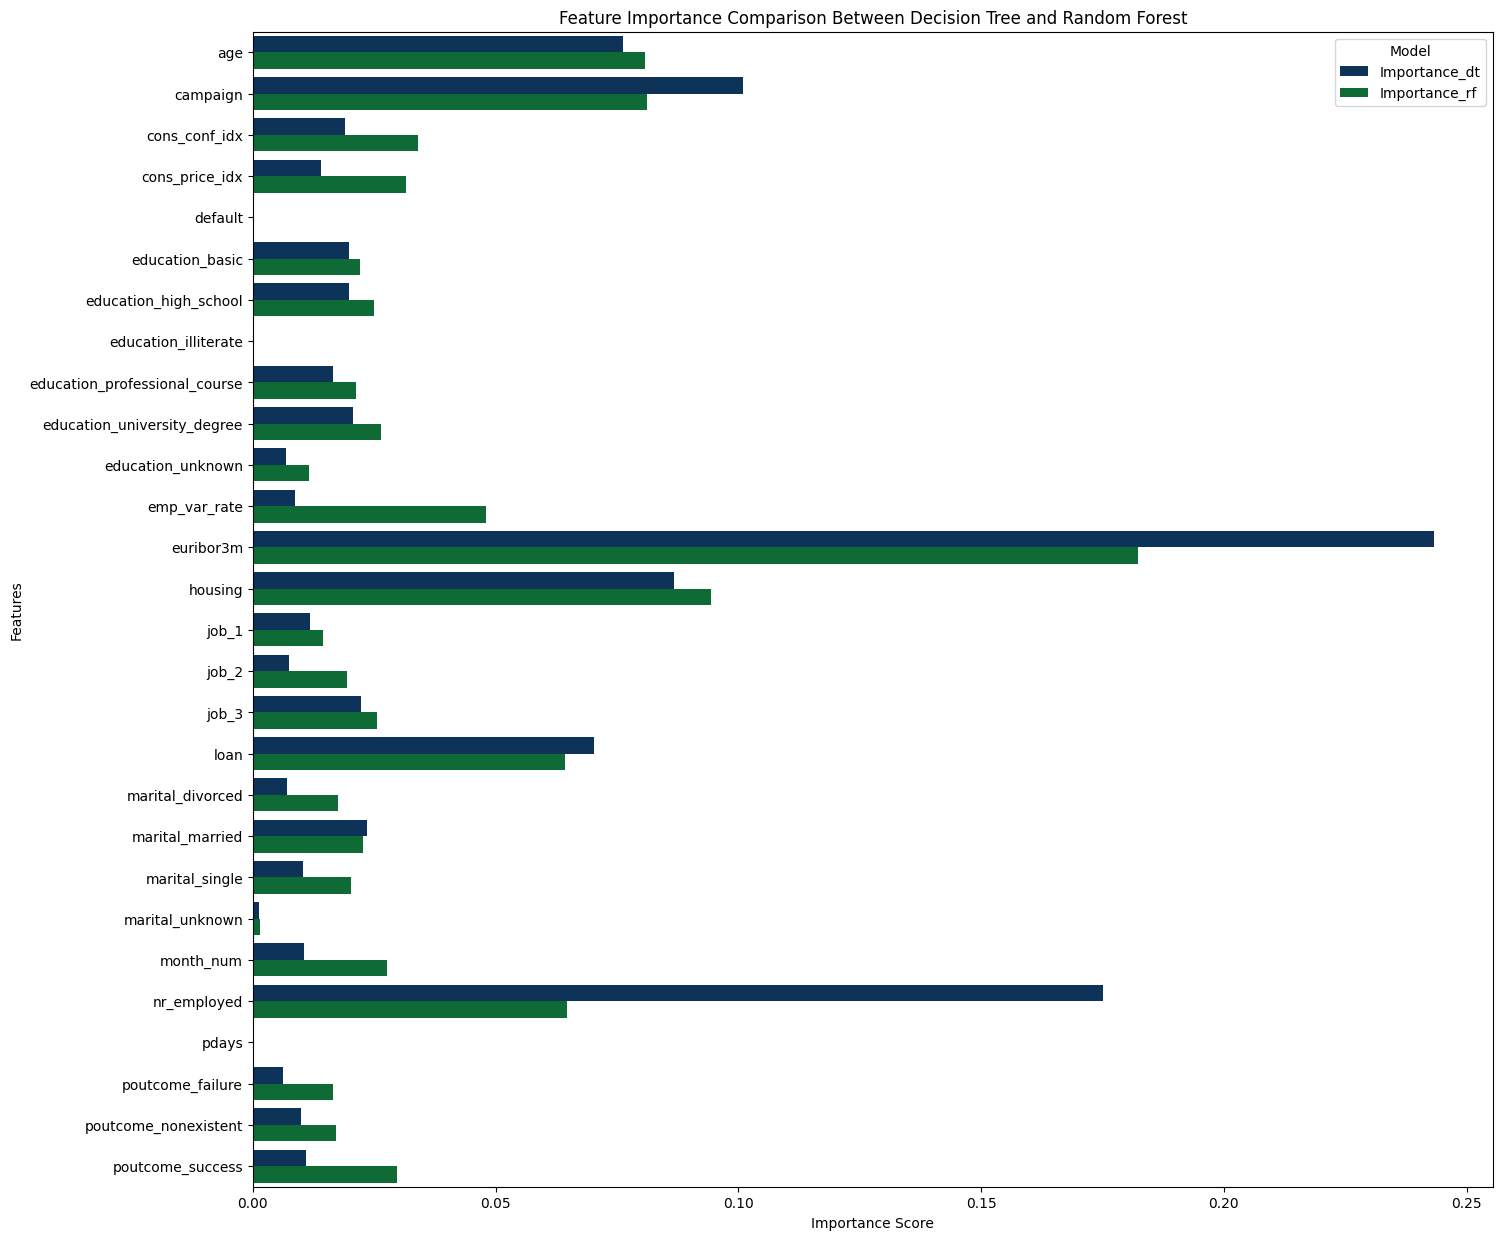

In [103]:
combined_df = pd.merge(dt_importance_df, rf_importance_df, on='Feature', how='outer', suffixes=('_dt', '_rf'))
combined_df = combined_df.melt(id_vars='Feature', value_vars=['Importance_dt', 'Importance_rf'], var_name='Model', value_name='Importance')

plt.figure(figsize=(16, 15))
sns.barplot(x='Importance', y='Feature', hue='Model', data=combined_df, palette=['#003366', '#007A33'])
plt.title('Feature Importance Comparison Between Decision Tree and Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.legend(title='Model')
plt.show()

For retraining the Decision Tree model, I've decided to exclude some of the one-hot encoded features after testing both scenarios (with and without them). The model showed higher accuracy without the one-hot encoded features.

For the Decision Tree, retaining the following features:
    "euribor3m",
    "nr_employed",
    "campaign",
    "housing",
    "loan",
    "age",
    "month_num",
    "cons_price_idx",
    "cons_conf_idx"

These are the most important features contributing to the model's performance.

## ***12. Retraining Decision Tree***

In [40]:
features_to_keep = ["euribor3m", "nr_employed", "campaign", "housing", "loan", "age", "month_num", "cons_price_idx", "cons_conf_idx"]
features_sdf = features_sdf.select(features_to_keep)

In [41]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

feature_columns = features_sdf.columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")
features_vec_sdf = assembler.transform(features_sdf)

scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(features_vec_sdf)
scaled_sdf = scaler_model.transform(features_vec_sdf)

scaled_sdf = scaled_sdf.drop("features_vec")
scaled_sdf.show(4)

+---------+-----------+--------+-------+----+---+---------+--------------+-------------+--------------------+
|euribor3m|nr_employed|campaign|housing|loan|age|month_num|cons_price_idx|cons_conf_idx|     scaled_features|
+---------+-----------+--------+-------+----+---+---------+--------------+-------------+--------------------+
|    4.857|     5191.0|     1.0|    0.0| 0.0|4.0|      5.0|        93.994|        -36.4|[2.60792096379953...|
|    4.857|     5191.0|     1.0|    0.0| 0.0|4.0|      5.0|        93.994|        -36.4|[2.60792096379953...|
|    4.857|     5191.0|     1.0|    1.0| 0.0|2.0|      5.0|        93.994|        -36.4|[2.60792096379953...|
|    4.857|     5191.0|     1.0|    0.0| 0.0|3.0|      5.0|        93.994|        -36.4|[2.60792096379953...|
+---------+-----------+--------+-------+----+---+---------+--------------+-------------+--------------------+
only showing top 4 rows



In [42]:
from pyspark.sql.functions import monotonically_increasing_id

scaled_sdf = scaled_sdf.withColumn("index", monotonically_increasing_id())
target_sdf = target_sdf.withColumn("index", monotonically_increasing_id())
data = scaled_sdf.join(target_sdf, "index").drop("index")

In [43]:
data = data.select("scaled_features", "y")

In [44]:
dt_train_data, dt_test_data = data.randomSplit([0.8, 0.2], seed=42)

In [45]:
start_time_train = time.time()
re_dt_model = crossval.fit(dt_train_data) 
end_time_train = time.time()

start_time_predict = time.time()
re_dt_predictions = re_dt_model.transform(dt_test_data)
end_time_predict = time.time()

In [46]:
re_dt_accuracy = dt_evaluator.evaluate(re_dt_predictions) * 100
print(f"Re-trained Decision Tree Accuracy: {re_dt_accuracy:.2f}%")

re_train_time = (end_time_train - start_time_train)
re_predict_time = (end_time_predict - start_time_predict)

print(f"Training Time: {re_train_time:.2f} seconds")
print(f"Prediction Time: {re_predict_time:.2f} seconds")

Re-trained Decision Tree Accuracy: 90.33%
Training Time: 300.45 seconds
Prediction Time: 0.10 seconds


In [47]:
re_precision = precision_evaluator.evaluate(re_dt_predictions) * 100
re_recall = recall_evaluator.evaluate(re_dt_predictions) * 100
re_f1_score = f1_evaluator.evaluate(re_dt_predictions) * 100
re_auc_roc = binary_evaluator.evaluate(re_dt_predictions) * 100

print(f"Decision Tree AUC-ROC: {re_auc_roc:.2f}")
print(f"Precision: {re_precision:.2f}")
print(f"Recall: {re_recall:.2f}")
print(f"F1 Score: {re_f1_score:.2f}")

Decision Tree AUC-ROC: 93.51
Precision: 87.83
Recall: 94.09
F1 Score: 90.31


In [48]:
metrics = {
    "Metric": ["Decision Tree Accuracy", "Training Time", "Prediction Time", "Decision Tree AUC-ROC", "Precision", "Recall", "F1 Score"],
    "Before Retraining": [f"{dt_accuracy:.2f}%", f"{train_time:.2f} seconds", f"{predict_time:.2f} seconds", f"{auc_roc:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1_score:.2f}"],
    "After Retraining": [f"{re_dt_accuracy:.2f}%", f"{re_train_time:.2f} seconds", f"{re_predict_time:.2f} seconds", f"{re_auc_roc:.2f}", f"{re_precision:.2f}", f"{re_recall:.2f}", f"{re_f1_score:.2f}"]
}

print(f"{'Metric':<30} {'Before Retraining':<20} {'After Retraining':<20}")
print("=" * 70)

for i in range(len(metrics["Metric"])):
    print(f"{metrics['Metric'][i]:<30} {metrics['Before Retraining'][i]:<20} {metrics['After Retraining'][i]:<20}")

Metric                         Before Retraining    After Retraining    
Decision Tree Accuracy         89.99%               90.33%              
Training Time                  472.80 seconds       300.45 seconds      
Prediction Time                0.25 seconds         0.10 seconds        
Decision Tree AUC-ROC          90.19                93.51               
Precision                      89.81                87.83               
Recall                         90.76                94.09               
F1 Score                       89.99                90.31               


## ***13. Retraining Random Forest***

In [20]:
features_to_keep = ["euribor3m", "housing", "campaign", "age", "loan", "nr_employed", "emp_var_rate", "cons_conf_idx", "cons_price_idx", "month_num", "poutcome_success", "education_university_degree", "job_3", "education_high_school", "marital_married", "education_basic", "education_professional_course", "marital_single", "job_2", "marital_divorced", "poutcome_nonexistent", "poutcome_failure", "job_1", "education_unknown"]
features_sdf = features_sdf.select(features_to_keep)

In [21]:
feature_columns = features_sdf.columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vec")
features_vec_sdf = assembler.transform(features_sdf)

scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features", withStd=True, withMean=False)
scaler_model = scaler.fit(features_vec_sdf)
scaled_sdf = scaler_model.transform(features_vec_sdf)

scaled_sdf = scaled_sdf.drop("features_vec")

In [22]:
scaled_sdf = scaled_sdf.withColumn("index", monotonically_increasing_id())
target_sdf = target_sdf.withColumn("index", monotonically_increasing_id())
data = scaled_sdf.join(target_sdf, "index").drop("index")

In [23]:
data = data.select("scaled_features", "y")

In [24]:
rf_train_data, rf_test_data = data.randomSplit([0.8, 0.2], seed=42)

In [25]:
start_time_rf_train = time.time()
re_rf_model = rf_tv_split.fit(rf_train_data) 
end_time_rf_train = time.time()

start_time_rf_predict = time.time()
re_rf_predictions = re_rf_model.transform(rf_test_data) 
end_time_rf_predict = time.time()

In [26]:
re_rf_train_time = (end_time_rf_train - start_time_rf_train)
re_rf_predict_time = (end_time_rf_predict - start_time_rf_predict)

re_rf_accuracy = dt_evaluator.evaluate(re_rf_predictions) * 100
print(f"Re-trained Random Forest Accuracy: {re_rf_accuracy:.2f}%")

print(f"Training Time: {re_rf_train_time:.2f} seconds")
print(f"Prediction Time: {re_rf_predict_time:.2f} seconds")

Re-trained Random Forest Accuracy: 92.23%
Training Time: 1424.23 seconds
Prediction Time: 0.10 seconds


In [27]:
re_rf_auc_roc = binary_evaluator.evaluate(re_rf_predictions) * 100
print(f"Random Forest AUC-ROC: {re_rf_auc_roc:.2f}")

re_rf_precision = precision_evaluator.evaluate(re_rf_predictions) * 100
re_rf_recall = recall_evaluator.evaluate(re_rf_predictions) * 100
re_rf_f1_score = f1_evaluator.evaluate(re_rf_predictions) * 100

print(f"Precision: {re_rf_precision:.2f}")
print(f"Recall: {re_rf_recall:.2f}")
print(f"F1 Score: {re_rf_f1_score:.2f}")

Random Forest AUC-ROC: 97.21
Precision: 90.90
Recall: 94.25
F1 Score: 92.22


In [29]:
rf_metrics = {"Metric": ["Random Forest Accuracy", "Training Time", "Prediction Time", "Random Forest AUC-ROC", "Precision", "Recall", "F1 Score"], 
              "Before Retraining": [f"{rf_accuracy:.2f}%", f"{rf_train_time:.2f} seconds", f"{rf_predict_time:.2f} seconds", f"{rf_auc_roc:.2f}", f"{rf_precision:.2f}", f"{rf_recall:.2f}", f"{rf_f1_score:.2f}"], 
              "After Retraining": [f"{re_rf_accuracy:.2f}%", f"{re_rf_train_time:.2f} seconds", f"{re_rf_predict_time:.2f} seconds", f"{re_rf_auc_roc:.2f}", f"{re_rf_precision:.2f}", f"{re_rf_recall:.2f}", f"{re_rf_f1_score:.2f}"]}

print(f"{'Metric':<30} {'Before Retraining':<20} {'After Retraining':<20}")
print("=" * 70)

for i in range(len(rf_metrics["Metric"])):
    print(f"{rf_metrics['Metric'][i]:<30} {rf_metrics['Before Retraining'][i]:<20} {rf_metrics['After Retraining'][i]:<20}")

Metric                         Before Retraining    After Retraining    
Random Forest Accuracy         92.07%               92.23%              
Training Time                  1933.35 seconds      1424.23 seconds     
Prediction Time                0.12 seconds         0.10 seconds        
Random Forest AUC-ROC          97.02                97.21               
Precision                      91.38                90.90               
Recall                         93.32                94.25               
F1 Score                       92.06                92.22               


## ***14. Algorithm Comparison***

In [53]:
true_labels_dt = dt_test_data.select("y").collect() 
true_labels_rf = rf_test_data.select("y").collect()

dt_pred_labels = re_dt_predictions.select("prediction").collect()  
rf_pred_labels = re_rf_predictions.select("prediction").collect()  

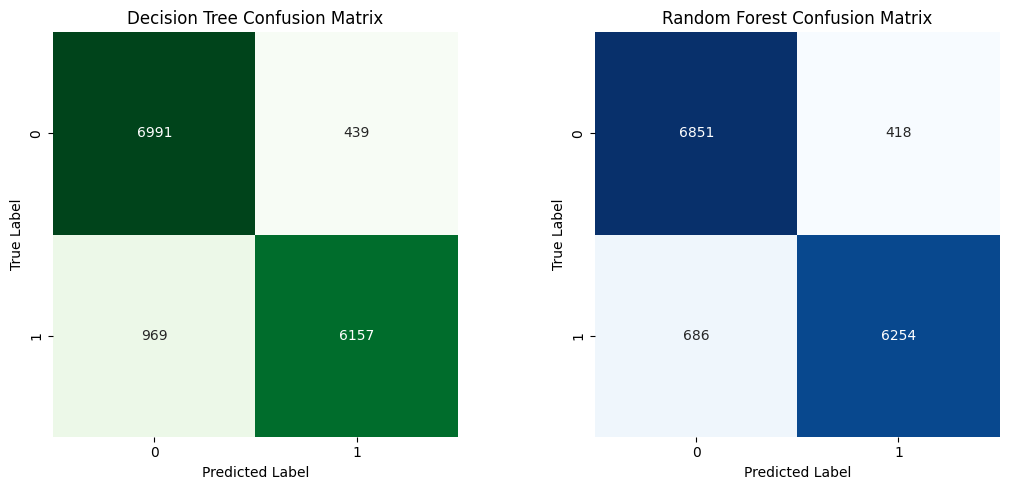

In [170]:
dt_conf_matrix = confusion_matrix(true_labels_dt, dt_pred_labels)
rf_conf_matrix = confusion_matrix(true_labels_rf, rf_pred_labels)
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

sns.heatmap(dt_conf_matrix, annot=True, fmt="d", cmap="Greens", square=True, cbar=False, ax=axs[0])
axs[0].set_title("Decision Tree Confusion Matrix")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", square=True, cbar=False, ax=axs[1])
axs[1].set_title("Random Forest Confusion Matrix")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")
plt.tight_layout()
plt.show()

In [189]:
metrics = {"Model": ["Decision Tree", "Retrained Decision Tree", "Random Forest", "Retrained Random Forest"],
    "Accuracy": [dt_accuracy, re_dt_accuracy, rf_accuracy, re_rf_accuracy],
    "AUC-ROC": [auc_roc, re_auc_roc, rf_auc_roc, re_rf_auc_roc],
    "Precision": [precision, re_precision, rf_precision, re_rf_precision],
    "Recall": [recall, re_recall, rf_recall, re_rf_recall],
    "F1 Score": [f1_score, re_f1_score, rf_f1_score, re_rf_f1_score]}
metrics_df = pd.DataFrame(metrics)

colors = {"Decision Tree": "#10751a", "Random Forest": "#142a94", "Retrained Decision Tree": "#07590f", "Retrained Random Forest": "#0a185c"}

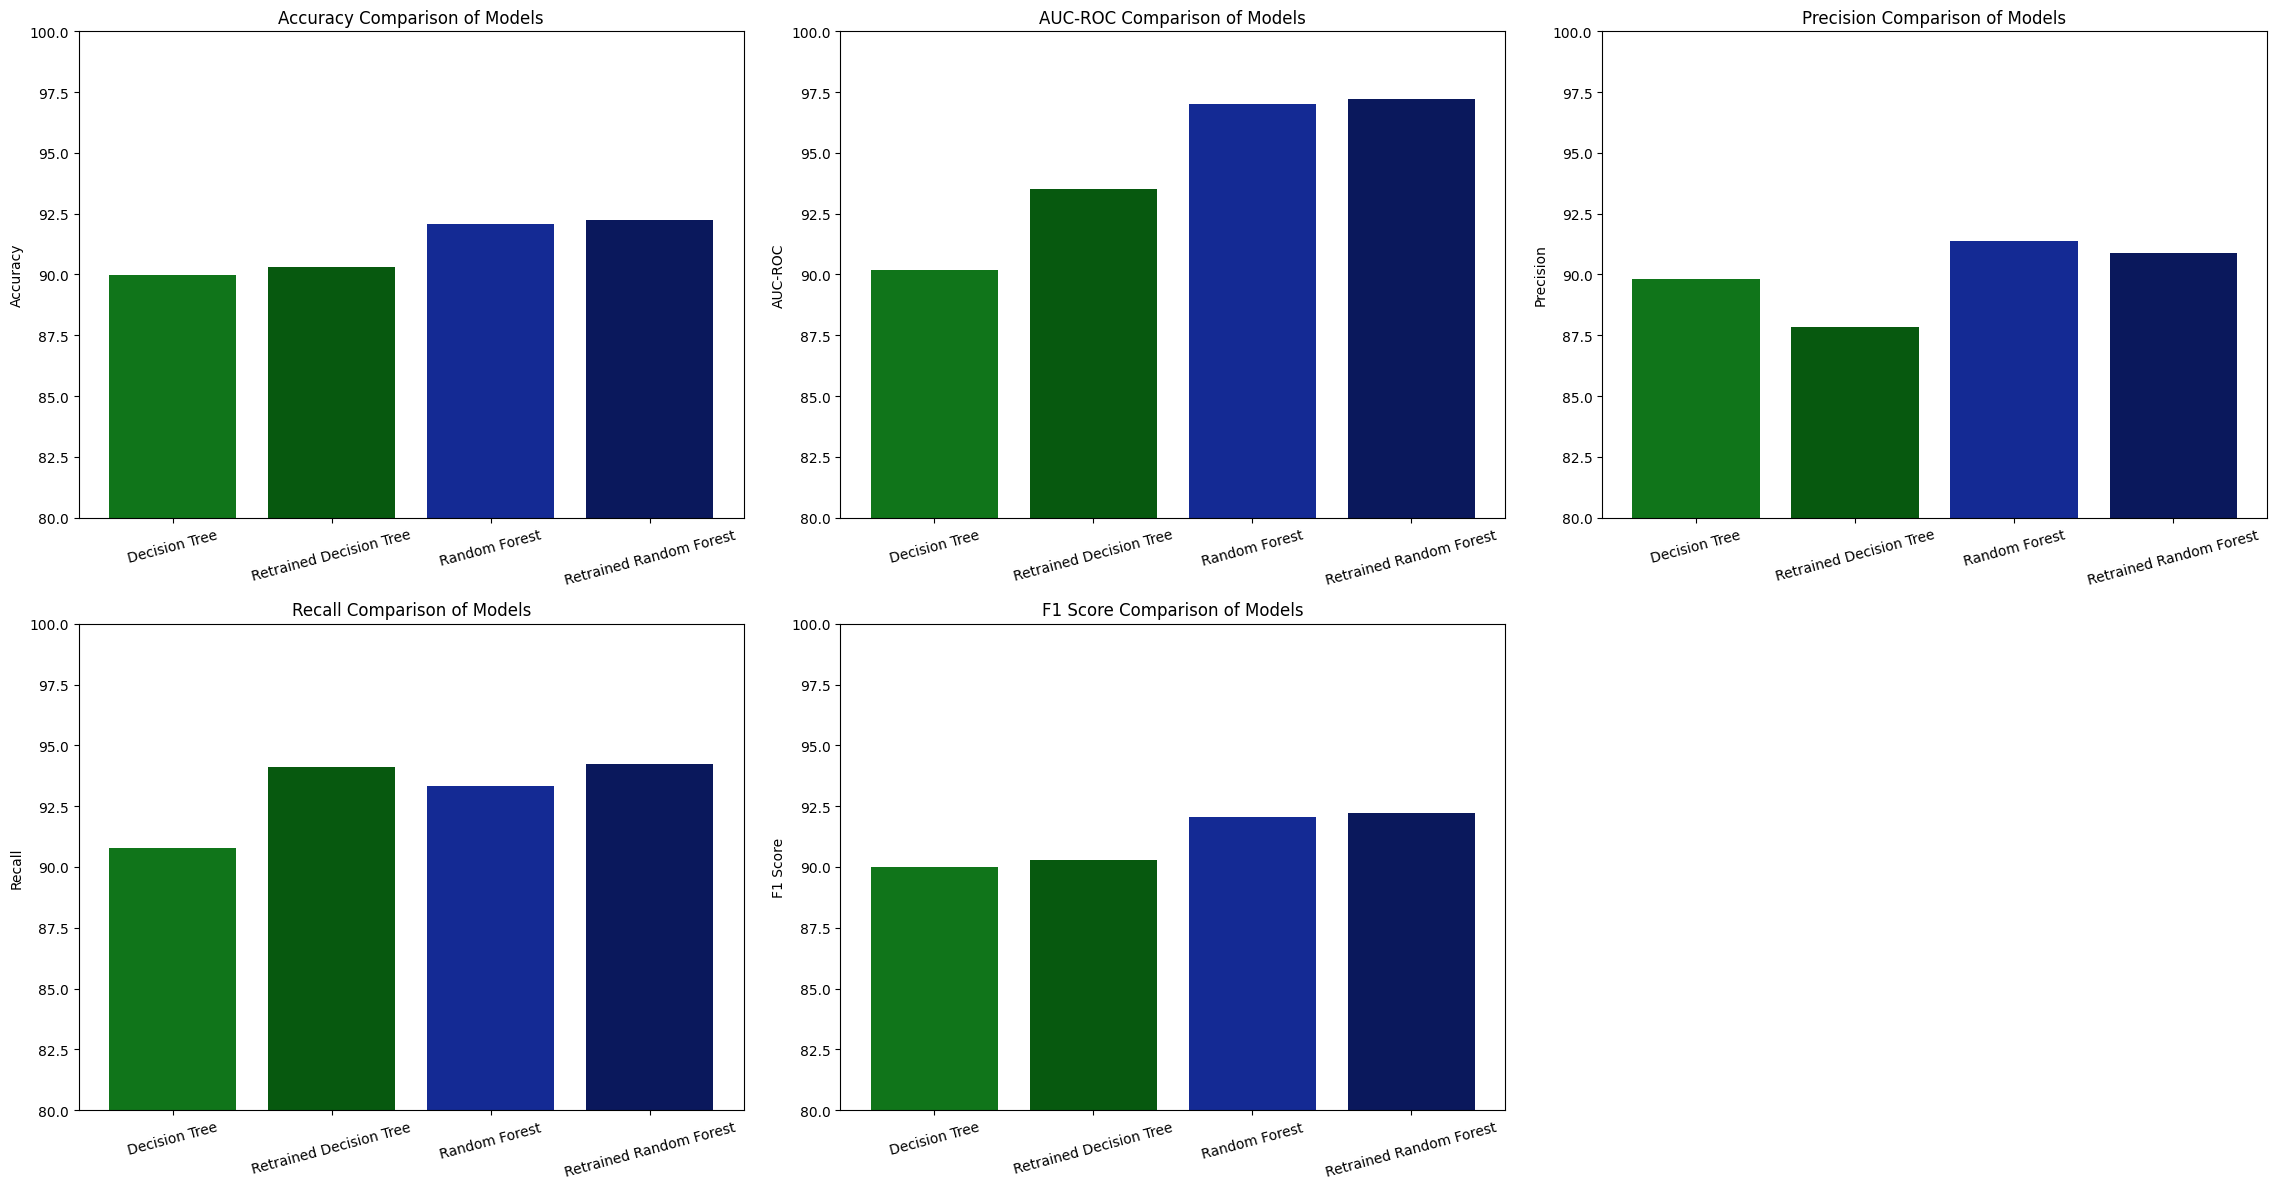

In [167]:
fig, axs = plt.subplots(2, 3, figsize=(23, 12))
axs = axs.flatten()

for i, metric in enumerate(metrics_df.columns[1:]):
    axs[i].bar(metrics_df["Model"], metrics_df[metric], color=[colors[model] for model in metrics_df["Model"]])
    axs[i].set_ylabel(metric)
    axs[i].set_title(f'{metric} Comparison of Models')
    axs[i].set_ylim(80, 100)  
    axs[i].tick_params(axis='x', rotation=15)  

if len(metrics_df.columns[1:]) < len(axs):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()

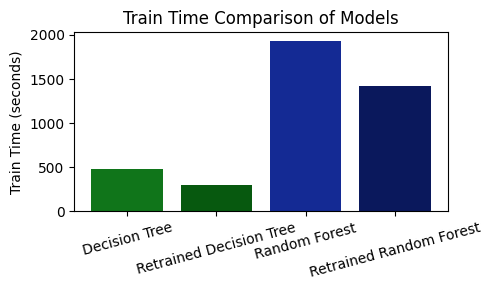

In [193]:
models = metrics_df["Model"].tolist()
train_times = [train_time, re_train_time, rf_train_time, re_rf_train_time]

plt.figure(figsize=(5, 3))
plt.bar(models, train_times, color=[colors[model] for model in models]) 
plt.ylabel('Train Time (seconds)')
plt.title('Train Time Comparison of Models')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [194]:
test_labels = test_data.select("y").rdd.flatMap(lambda x: x).collect() 

In [195]:
def get_predicted_probs_and_auc(model, test_data, test_labels):
    predictions = model.transform(test_data)
    predicted_probs = predictions.select("probability").rdd.flatMap(lambda x: x).collect()
    predicted_probs = [prob[1] for prob in predicted_probs] 
    fpr, tpr, _ = roc_curve(test_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

In [196]:
test_labels_dt = test_data.select("y").rdd.flatMap(lambda x: x).collect()
test_labels_rf = test_data.select("y").rdd.flatMap(lambda x: x).collect()
test_labels_re_dt = dt_test_data.select("y").rdd.flatMap(lambda x: x).collect()
test_labels_re_rf = rf_test_data.select("y").rdd.flatMap(lambda x: x).collect()

In [197]:
fpr_dt, tpr_dt, roc_auc_dt = get_predicted_probs_and_auc(dt_model, test_data, test_labels_dt)
fpr_rf, tpr_rf, roc_auc_rf = get_predicted_probs_and_auc(rf_model, test_data, test_labels_rf)
fpr_re_dt, tpr_re_dt, roc_auc_re_dt = get_predicted_probs_and_auc(re_dt_model, dt_test_data, test_labels_re_dt)
fpr_re_rf, tpr_re_rf, roc_auc_re_rf = get_predicted_probs_and_auc(re_rf_model, rf_test_data, test_labels_re_rf)

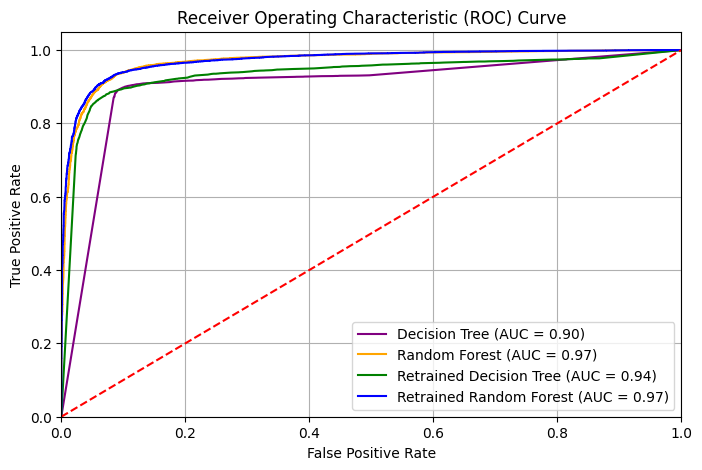

In [198]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_dt, tpr_dt, color='purple', label='Decision Tree (AUC = {:.2f})'.format(roc_auc_dt))
plt.plot(fpr_rf, tpr_rf, color='orange', label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot(fpr_re_dt, tpr_re_dt, color='green', label='Retrained Decision Tree (AUC = {:.2f})'.format(roc_auc_re_dt))
plt.plot(fpr_re_rf, tpr_re_rf, color='blue', label='Retrained Random Forest (AUC = {:.2f})'.format(roc_auc_re_rf))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## ***15. Conclusion***

| Metric               | Decision Tree   | Random Forest  |
|----------------------|------------------------|-----------------------|
| **Accuracy**             | 90.33%                 | 92.23%                |
| **Training Time**        | 300.45 seconds           | 1424.23 seconds        |
| **Prediction Time**      | 0.1 seconds           | 0.1 seconds          |
| **AUC-ROC**              | 93.51                  | 97.21                 |
| **Precision**            | 87.83                  | 90.90                 |
| **Recall**               | 94.09                  | 94.25                 |
| **F1 Score**             | 90.31                  | 92.22                 |

**Conclusion:**

In comparing the Decision Tree and Random Forest models, the Random Forest consistently outperforms the Decision Tree across all key metrics. While it provides superior predictive performance, it requires significantly longer training time. The Decision Tree, on the other hand, offers efficiency with faster training, making it a viable option when speed is essential.

The choice between these models should consider the trade-off between accuracy and training duration. Random Forest is preferable for applications where higher accuracy is crucial, while Decision Trees are suitable for scenarios prioritizing speed. This flexibility provided by PySpark enables tailored model selection based on specific performance metrics aligned with project goals, whether they prioritize speed or accuracy.